In [16]:
# NOTE:
# Adversarial PINN. The PINN outputs the prediction to u(phi) given phi, along with the physics loss of the 1st and 2nd
# differentail equations (we also output the target of the physics eq.). 
# We make a second network (critic) to predict if the input tensors are real (from the data itself) or fake (generated from PINN)
# Specifically we input the following:
#       [input tensor for data, input tensor for physics, difference between ode1 and target of ode1, same for ode2, output of model (or target if we are inputing the real values)]

# This should give better gradients to the "generator" (the PINN in our case), which should yield better updates to the model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


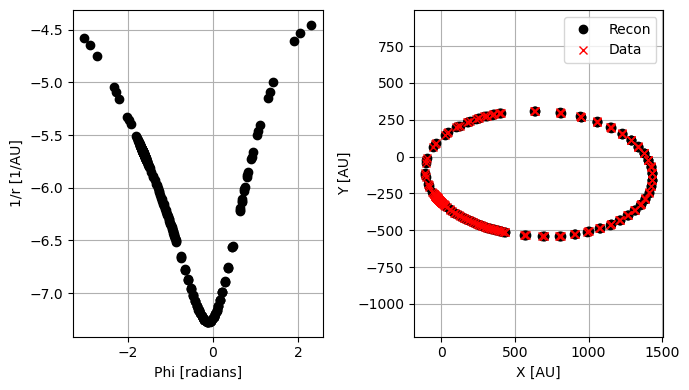

In [2]:
micro_arcsec_to_au = torch.pi / (3600*180) * 8 * 1000 * 206265 * 1 # to units 1e-2 AU

data = pd.read_csv("data/simulated_data.csv")
y = torch.tensor(data.iloc[:,1], dtype=torch.float32) * micro_arcsec_to_au
x = torch.tensor(data.iloc[:,2], dtype=torch.float32) * micro_arcsec_to_au

#phi = np.arctan(y/x).unsqueeze(1)
u = (1/np.sqrt(x**2 + y**2))


phi = np.arccos(x*u) 
phi = torch.where(y<0., -phi, phi).float()
#phi = torch.where(phi<0, phi+2*torch.pi, phi)
phi = torch.where(phi>2.2*torch.pi, phi-2*torch.pi, phi)


u = u.unsqueeze(1)
phi = phi.unsqueeze(1)

fig, ax = plt.subplots(figsize=(7,4), ncols=2)
#ax.set_xscale("log")

ax[0].plot(phi, torch.log(u), 'ko')
ax[0].set_ylabel("1/r [1/AU]")
ax[0].set_xlabel("Phi [radians]")

ax[1].plot(np.cos(phi[:,0])/u[:,0], np.sin(phi[:,0])/u[:,0], 'ko', label="Recon")
ax[1].plot(x, y, 'rx', label="Data")
ax[1].set_ylabel("Y [AU]")
ax[1].set_xlabel("X [AU]")
ax[1].legend()

ax[1].axis('equal')

[axi.grid() for axi in ax]

plt.tight_layout()


In [3]:
""" Generator """

def grad(out, inp):
    return torch.autograd.grad(out, 
                               inp, 
                               grad_outputs=torch.ones_like(out), 
                               create_graph=True,
                               allow_unused=True,
                               retain_graph=True)


class NNBlock(nn.Module):
    """
    Standard Feed Forward Neural Network 
    """
    def __init__(self, in_chan, out_chan, chans=[5,10,5], dropout_prob=0.1):
        super().__init__()

        #self.in_block = nn.Linear(in_chan, chans[0])

        layers = []

        layers.append(nn.Linear(in_chan, chans[0]))
        layers.append(nn.Tanh())
        #layers.append(nn.Dropout(p=dropout_prob))

        for i in range(len(chans) - 1):
            layers.append(nn.Linear(chans[i], chans[i+1]))
            layers.append(nn.Tanh())
            #layers.append(nn.Dropout(p=dropout_prob))

        layers.append(nn.Linear(chans[-1], out_chan))

        self.blocks = nn.Sequential(*layers)

    def forward(self, x):
        #y = torch.sin(self.in_block(x))
        #return self.blocks(y)
    
        return self.blocks(x)


class PINN(nn.Module):
    """
    Physics Informed Neural Network. 
        * physical_loss :
            Calculates the physical loss using 
            - returns torch.tensor
    """
    def __init__(self, in_chan=1, out_chan=1, chans=[5,10,5]):
        super().__init__()

        # Predicts Chi
        self.nn = NNBlock(in_chan, out_chan, chans=chans)

        self.e_ = torch.nn.Parameter(torch.abs(torch.randn(3)/10))
        self.mu_ = torch.nn.Parameter(torch.abs(torch.randn(3)/10))
        self.M_ = torch.nn.Parameter(torch.abs(torch.randn(3)/10))

        # Use initial guess
        # self.e_ = torch.nn.Parameter(torch.arctanh(torch.tensor(0.8))) # 0.8

    def forward(self, x):
        mu = self.get_mu()#.item()
        M  = self.get_M()
        e  = self.get_e()#.item()

        u = mu/M * (1 + e*torch.cos(self.nn(x)))
        return u
    
    def get_e(self):
        return torch.tanh(torch.abs(self.e_[0]*self.e_[1] + self.e_[2]))
    
    def get_M(self):
        return torch.abs(self.M_[0]*self.M_[1] + self.M_[2])
    
    def get_mu(self):
        return torch.abs(self.mu_[0]*self.mu_[1] + self.mu_[2])
    
    def get_p(self):
        return self.get_M()/self.get_mu()

    def physics(self, phi):
        chi = self.nn(phi)

        mu = self.get_mu().item()
        e  = self.get_e().item()

        dchi = grad(chi, phi)[0] 
        ddchi = grad(dchi, phi)[0]

        # ode1 model, ode1 target, ode2 model, ode2 target
        return dchi**2, (1 - 2*mu*(3 + e*torch.cos(chi))), ddchi, mu*e*torch.sin(chi)

    def physical_loss(self, phi, lambda1=1., lambda2=1.):
        chi = self.nn(phi)

        mu = self.get_mu().detach()#.item()
        #p  = self.get_p()
        #M  = self.get_M()
        e  = self.get_e()#.item()

        dchi = grad(chi, phi)[0] 
        ddchi = grad(dchi, phi)[0]
        # phi.detach_()

        ode1 = dchi**2 - (1 - 2*mu*(3 + e*torch.cos(chi)))
        ode2 = ddchi - mu*e*torch.sin(chi)

        loss1 = torch.mean(ode1**2)
        loss2 = torch.mean(ode2**2)
        
        # L1 Loss
        #loss1 = torch.mean(torch.abs(ode1))
        #loss2 = torch.mean(torch.abs(ode2))

        loss1 *= lambda1
        loss2 *= lambda2

        #print(loss1, loss2)
        return loss1 + loss2

In [4]:
class Critic(nn.Module):
    """
    Critic (Discriminator) network for Wasserstein GAN.
    Outputs a scalar score for real and generated samples.
    """
    def __init__(self, in_chan, chans=[8,16,16,8]):
        super().__init__()
        layers = []
        layers.append(nn.Linear(in_chan, chans[0]))
        layers.append(nn.LeakyReLU(0.2))

        for i in range(len(chans) - 1):
            layers.append(nn.Linear(chans[i], chans[i+1]))
            layers.append(nn.LeakyReLU(0.2))

        layers.append(nn.Linear(chans[-1], 1))  # Output a single scalar score
        self.blocks = nn.Sequential(*layers)

    def forward(self, x):
        return self.blocks(x)


def wgan_grad_penalty(critic, x, y, lam=10):
    """Calculate the gradient penalty for WGAN
    """
    device = x.device
    batch_size = x.shape[0]
    alpha = torch.rand(batch_size, device=device)
    alpha = alpha.reshape(batch_size, *(1,) * (x.dim() - 1))

    xy = alpha * x.detach() + (1 - alpha) * y.detach()

    score = critic(xy.requires_grad_(True))
    # average over spatial dimensions if present
    score = score.flatten(start_dim=1).mean(dim=1)
    # sum over batches because graphs are mostly independent (w/o batchnorm)
    score = score.sum()

    grad, = torch.autograd.grad(
        score,
        xy,
        retain_graph=True,
        create_graph=True,
        only_inputs=True,
    )

    grad = grad.flatten(start_dim=1)
    penalty = (
        lam * ((grad.norm(p=2, dim=1) - 1) ** 2).mean()
        + 0 * score  # hack to trigger DDP allreduce hooks
    )

    return penalty


class WDistLoss(nn.Module):
    """Wasserstein distance

    target should have values of 0 (False) or 1 (True)
    """
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        return wasserstein_distance_loss(input, target)


def wasserstein_distance_loss(input, target):
    sign = 2 * target - 1

    return - (sign * input).mean()

def set_requires_grad(module, requires_grad=False):
    for param in module.parameters():
        param.requires_grad = requires_grad

In [17]:
model = PINN(1, 1, chans=[32,32,32,32,32]).to(device)
adv_model = Critic(5, chans=[32,32,32,32,32]).to(device) # input catinated input, output, phys model 1 and 2

# Params
lr = 1e-4
lr_adv = 2 * 1e-4 # 2e-5

adv_start = 1
lambda_gp = 10  # Gradient penalty weight
adv_grad_penalty_interval = 16

alpha = 0.99
w_mse_old = 1.
w_phys_old = 1.

batch_size = 128
batch_size_phys = batch_size

betas = (0.0, 0.99) # (0.9, 0.999)


optimizer = optim.Adam(lr=lr, params=model.parameters(), betas=betas)
optimizer_adv = optim.Adam(lr=lr_adv, params=adv_model.parameters(), betas=betas)
criterion = nn.MSELoss()
criterion_adv = WDistLoss()


losses = [[], []]       # MSEloss, PHYSloss
adv_loss = [[], []]     # Real, fake
perceptual_losss = []
params = [[], [], []]   # ...

#phi_lin = torch.linspace(-2.1*torch.pi, 4.2*torch.pi, steps=1000).view(-1,1).requires_grad_(True)
N = 2.  # How many pi do I want to extend the angles with, when evaluating the physics
phi_lin = torch.linspace(phi.min() - torch.pi*N, phi.max() + torch.pi*N, steps=256).view(-1,1).requires_grad_(True)


fake = torch.zeros([1], dtype=torch.float32, device=device)
real = torch.ones([1], dtype=torch.float32, device=device)
adv_real = torch.full([1], 1, dtype=torch.float32, device=device)

epoch = 0

In [ ]:
epochs = 30_000

# For rel.diff. loss use phys_loss_weight = 1e0

for i in tqdm(range(epochs)):
    epoch += 1

    ind = torch.tensor(random.sample(range(len(phi)), batch_size))
    ind_p = torch.tensor(random.sample(range(len(phi_lin)), batch_size_phys))

    input = phi[ind]; 
    input = (input + (torch.randint(low=0,high=3,size=input.shape) - 1) * 2 * torch.pi)
    input = input.to(device)
    
    target = u[ind]; target = target.to(device)
    input_p = phi_lin[ind_p]; input_p = input_p.to(device)
    
    output = model(input)


    MSEloss = criterion(output, target)
    PHYSloss = model.physical_loss(input_p)

    losses[0].append(MSEloss.item())
    losses[1].append(PHYSloss.item())

    set_requires_grad(adv_model, True)

    if not epoch >= adv_start:
        # LOSS NORMALIZATION
        w_mse = ((MSEloss + PHYSloss)/(MSEloss)).item()
        w_phys = ((MSEloss + PHYSloss)/(PHYSloss)).item()

        w_mse = alpha * w_mse_old + (1 - alpha) * w_mse
        w_phys = alpha * w_phys_old + (1 - alpha) * w_phys

        MSEloss *= w_mse
        PHYSloss *= w_phys

        loss = MSEloss + PHYSloss

        w_mse_old = w_mse
        w_phys_old = w_phys


        optimizer.zero_grad()
        loss.backward()
        #MSEloss.backward()
        #PHYSloss.backward()
        optimizer.step()
    else: 
        output_ode1, target_ode1, output_ode2, target_ode2 = model.physics(input_p)

        #output = torch.cat([input, output_ode1, output_ode2, output], dim=1)
        #target = torch.cat([input, target_ode1, target_ode2, target], dim=1)

        diff1 = (output_ode1 - target_ode1)**2
        diff2 = (output_ode2 - target_ode2)**2
        output = torch.cat([input, input_p, diff1, diff2, torch.log(output)], dim=1)
        target = torch.cat([input, input_p, torch.zeros_like(diff1), torch.zeros_like(diff2), torch.log(target)], dim=1)

        #noise = torch.randn_like(output) * 0.0018/3 * max(1 - epoch/50000, 0)
        #output += noise
        #target += noise

        score_out = adv_model(output.detach())
        adv_loss_fake = criterion_adv(score_out, fake.expand_as(score_out))
        adv_loss[0].append(adv_loss_fake.item())

        optimizer_adv.zero_grad()
        adv_loss_fake.backward()

        score_tgt = adv_model(target)
        adv_loss_real = criterion_adv(score_tgt, adv_real.expand_as(score_tgt))
        adv_loss[1].append(adv_loss_real.item())

        adv_loss_real.backward(retain_graph=True)

        if epoch % adv_grad_penalty_interval == 0:
                adv_loss_reg = wgan_grad_penalty(adv_model, output, target)
                adv_loss_reg_ = adv_loss_reg * adv_grad_penalty_interval
                adv_loss_reg_.backward()

        optimizer_adv.step()

        set_requires_grad(adv_model, False)
        score_out = adv_model(output)
        loss_adv = criterion_adv(score_out, real.expand_as(score_out))
        
        perceptual_losss.append(loss_adv.item())
        #        epoch_loss[1] += loss_adv.detach()
        optimizer.zero_grad()
        loss_adv.backward(retain_graph=True)
        optimizer.step()

        

    params[0].append(model.get_e().item())
    params[1].append(model.get_mu().item())
    #params[1].append(model.get_p().item())
    params[2].append(model.get_M().item())

    #phys_loss_weight += .005 # * (phys_loss_weight < 10)
    # phys_loss_weight += lr * 5

 27%|██▋       | 7974/30000 [02:42<07:31, 48.83it/s]

tensor(0.1652, grad_fn=<MeanBackward0>)
tensor(0.0260, grad_fn=<MeanBackward0>)


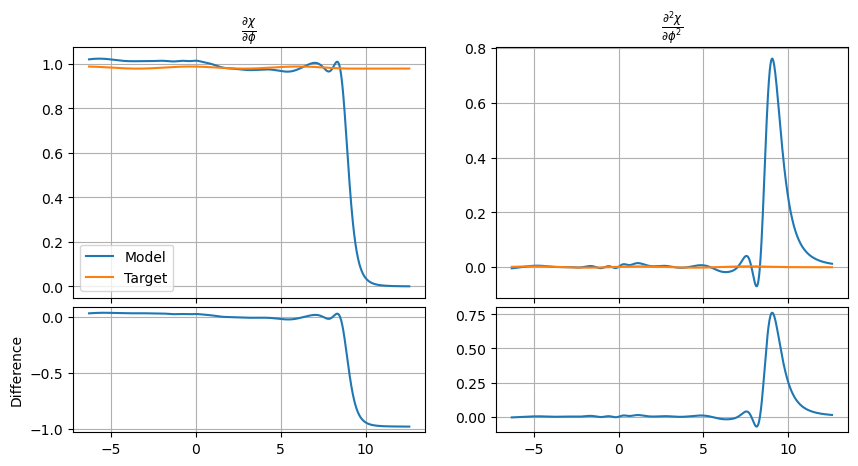

In [ ]:
def grad(out, inp):
    return torch.autograd.grad(out, 
                               inp, 
                               grad_outputs=torch.ones_like(out), 
                               create_graph=True)

_phi = phi_lin #torch.linspace(-2*torch.pi, 4*torch.pi, steps=1000).view(-1,1).requires_grad_(True)
chi = model.nn(_phi)

mu = model.get_mu().item()
#p  = self.get_p()
#M  = self.get_M()
e  = model.get_e().item()

dchi = grad(chi, _phi)[0]
ddchi = grad(dchi, _phi)[0]

ode1 = dchi**2 - (1 - 2*mu*(3 + e*torch.cos(chi)))
ode2 = ddchi - mu*e*torch.sin(chi)

print(torch.mean(ode1**2))
print(torch.mean(ode2**2))

_phi = _phi.detach().numpy()
dchi = dchi.detach().numpy()
ddchi = ddchi.detach().numpy()
chi = chi.detach()
ode1 = ode1.detach().numpy()
ode2 = ode2.detach().numpy()

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,5), gridspec_kw={'height_ratios':[2,1]}, sharex=True)
ax[0,0].grid()
ax[0,0].set_title(r"$\frac{\partial \chi}{\partial \phi}$")
ax[0,0].plot(_phi, dchi**2, label="Model")
ax[0,0].plot(_phi, (1 - 2*mu*(3 + e*torch.cos(chi))), label="Target")
ax[0,0].legend()

ax[0,1].grid()
ax[0,1].set_title(r"$\frac{\partial^2 \chi}{\partial \phi^2}$")
ax[0,1].plot(_phi, ddchi)
ax[0,1].plot(_phi, mu*e*torch.sin(chi))

ax[1,0].grid()
ax[1,0].set_ylabel("Difference")
ax[1,0].plot(_phi, ode1)

ax[1,1].grid()
ax[1,1].plot(_phi, ode2)

plt.subplots_adjust(hspace=.05)

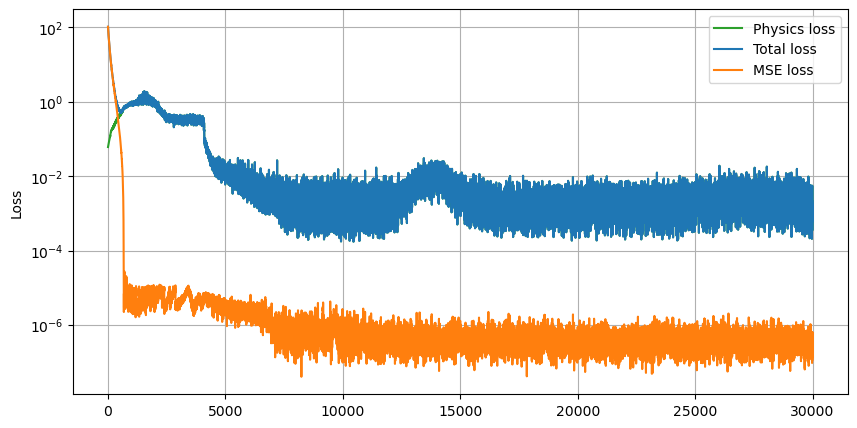

In [ ]:

fig, ax  = plt.subplots(figsize=(10,5), ncols=1)

ax.plot(losses[1], label="Physics loss", c="tab:green")
ax.plot(np.array(losses[0]) + np.array(losses[1]), label="Total loss", c="tab:blue")
ax.plot(losses[0], label="MSE loss", c="tab:orange")

ax.grid()
ax.set_ylabel("Loss")

ax.legend()
ax.set_yscale("log")
plt.show()


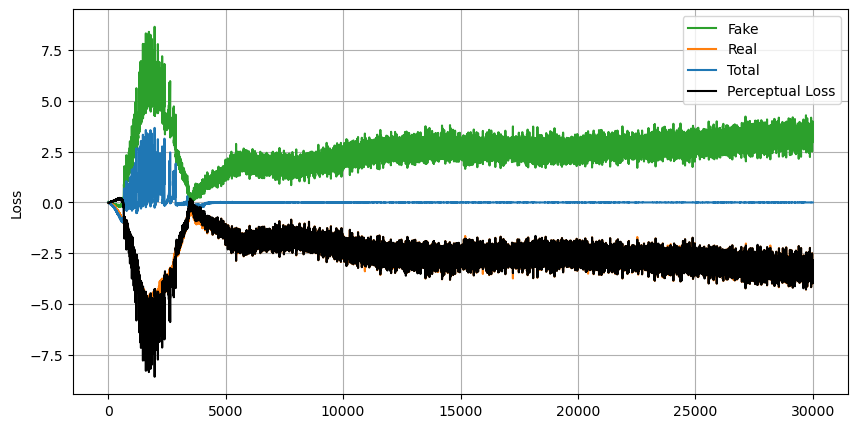

In [ ]:

fig, ax  = plt.subplots(figsize=(10,5), ncols=1)

ax.plot(adv_loss[0], label="Fake", c="tab:green")
ax.plot(adv_loss[1], label="Real", c="tab:orange")
ax.plot(np.array(adv_loss[0]) + np.array(adv_loss[1]), label="Total", c="tab:blue")
ax.plot(range(adv_start, epoch+1), perceptual_losss, 'k', label="Perceptual Loss")


ax.grid()
ax.set_ylabel("Loss")

ax.legend()
#ax.set_yscale("log")
plt.show()


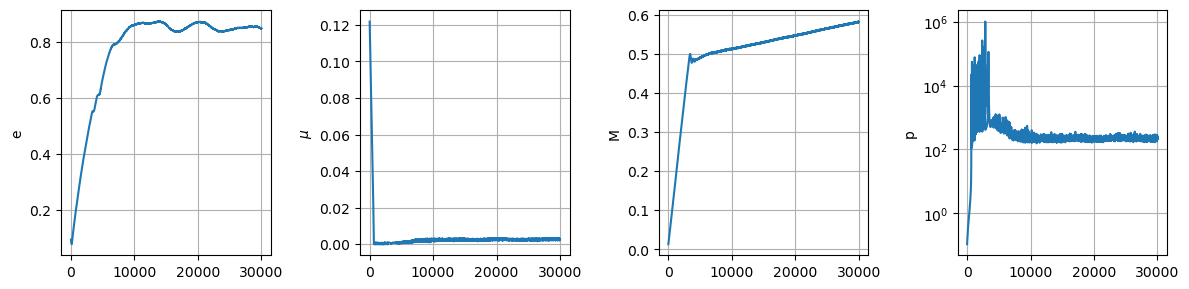

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(12,3))

ax[0].plot(params[0])
ax[0].set_ylabel("e")
ax[0].grid()

ax[1].plot(params[1])
ax[1].set_ylabel(r"$\mu$")
#ax[1].set_ylabel("p")
ax[1].grid()

ax[2].plot(params[2])
ax[2].set_ylabel("M")
ax[2].grid()

ax[3].plot(np.array(params[2])/np.array(params[1]))
ax[3].set_ylabel("p")
ax[3].grid()
ax[3].set_yscale("log")

plt.tight_layout()
plt.show()


In [ ]:
print("e =", model.get_e().item())
#print("p =", model.get_M().item()/model.get_mu().item())
print("p =", model.get_p().item())
print("M =", model.get_M().item())
print("mu =", model.get_mu().item())


M_md = torch.mean(1 - torch.abs(model(phi.to(device)).cpu() - u)/u).item()
print("M-model-data =", M_md)

# e  ~ 0.884 (0.884)
# p  ~ 228 (223)
# mu ~ 1.8e-4
# M  ~ 0.04239 AU

# M-model-data ~ 0.9755

e = 0.8485172986984253
p = 210.20193481445312
M = 0.5815190076828003
mu = 0.0027664778754115105
M-model-data = 0.8690437078475952


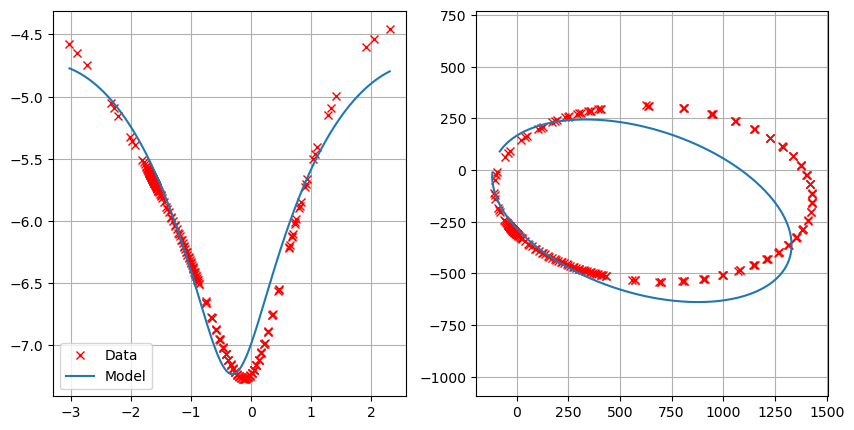

In [ ]:
fig, ax = plt.subplots(figsize=(10,5), ncols=2)
_phi = phi
_u = u
ax[0].plot(_phi, torch.log(_u), 'rx', label="Data")


theta = torch.linspace(_phi.min(), _phi.max(), steps=1000, dtype=torch.float32).to(device)
u_ = model(theta.unsqueeze(1)).cpu().detach().numpy()[:,0]
theta = theta.cpu()
ax[0].plot(theta, np.log(u_), label="Model")
#ax[0].vlines(torch.pi/2, _u.min(), _u.max(), 'k', ls='--')
#ax[0].vlines(3*torch.pi/2, _u.min(), _u.max(), 'k', ls='--')
#ax[0].vlines(2*torch.pi, _u.min(), _u.max(), 'r', ls='--')
#ax[0].vlines(torch.pi, _u.min(), _u.max(), 'r', ls='--')


#ax[1].plot(x1, y1, 'rx')
#ax[1].plot(x2, y2, 'rx')
ax[1].plot(torch.cos(_phi[:,0])/_u[:,0], torch.sin(_phi[:,0])/_u[:,0], "rx")

r = 1/u_

theta = theta.numpy()
ax[1].plot(r*np.cos(theta), r*np.sin(theta));


[axi.grid() for axi in ax]
ax[1].axis('equal')
#ax[0].axis('equal')
ax[0].legend();
#ax.set_xscale("log")
#ax[0].set_xlim(0,3)
#ax[0].set_ylim(0,2)

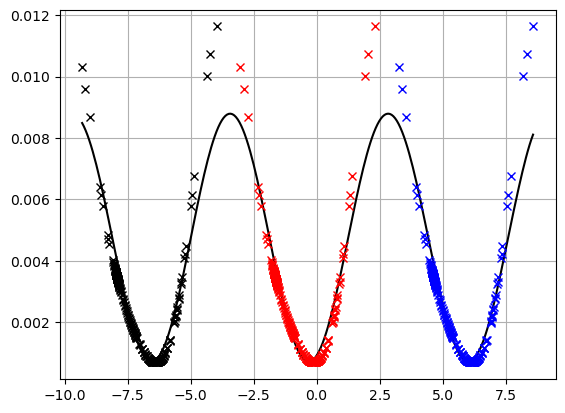

In [ ]:
fig, ax = plt.subplots()
ax.grid()

u_ = model(phi_lin).cpu().detach().numpy()[:,0]
theta = phi_lin.cpu().detach().numpy()

ax.plot(theta[:,0], u_, 'k')


ax.plot(phi.cpu(), u.cpu(), "rx")
phi_aug_ = phi + 2 * torch.pi
ax.plot(phi_aug_.cpu(), u.cpu(), 'bx')
phi_aug = phi - 2 * torch.pi
ax.plot(phi_aug.cpu(), u.cpu(), 'kx')

#plt.xlim(-2, -1)
#r = 1/u_
#theta = phi_lin.detach().numpy()
#ax.plot(r*np.cos(theta[:,0]), r*np.sin(theta[:,0]));


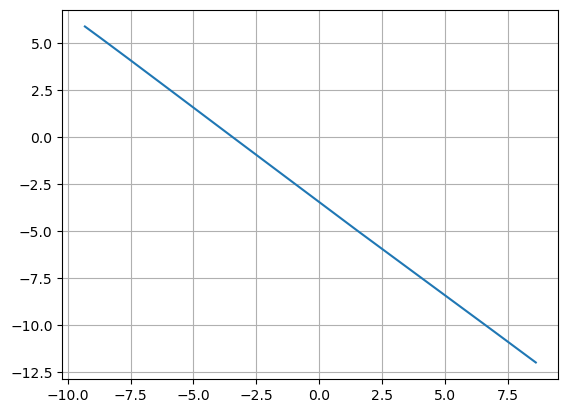

In [ ]:
x = phi_lin
y = model.nn(x)

x = x.cpu().detach().numpy()
y = y.cpu().detach().numpy()

plt.plot(x,y)
plt.grid()

In [ ]:
state = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}

#torch.save(state, f'S-STAR-PINN.pth')